In [1]:
!pip install import_ipynb
!pip3 install wheel
!pip install pygco


In [2]:
%run preprocess.ipynb
%run clustering.ipynb
%run graph_cut.ipynb
%run ImageMetric.ipynb

In [3]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
import pickle

In [4]:
def create_train_set(filename,number_of_colors = 32,window = 15):
    size = 600, 400
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    im_lab = cv2.cvtColor(np.array(im_resized),cv2.COLOR_BGR2LAB)
    im_lab_np = np.array(im_lab)
    grayscale_img = im_lab[:,:,0]
    y,centers = create_label(im_lab_np[:,:,1:],number_of_colors ,window)#number of colors and window size
    feature_vector = all_feature_vector(grayscale_img,window)#window
    feature_vector = np.transpose(feature_vector)
    min_max_scaler = MinMaxScaler()
    feature_vector = min_max_scaler.fit_transform(feature_vector)
    pca = PCA(n_components=30)
    pca.fit(feature_vector)
    print(np.sum(pca.explained_variance_ratio_))
    x = pca.transform(feature_vector)
    return x , y,centers,pca,min_max_scaler,grayscale_img[int(window/2):-int(window/2), int(window/2):-int(window/2)]

In [5]:
def create_test_set(grayscale_img,pca,scaler,window=15):
    feature_vector = all_feature_vector(grayscale_img,window)#window
    feature_vector = np.transpose(feature_vector)
    feature_vector = scaler.transform(feature_vector)
    x_test = pca.transform(feature_vector)
    return x_test

In [6]:
def train_svm(x,y,number_of_colors, c = 1):
    svm_arr = []
    for i in range(number_of_colors):
        y_train = (y == i).astype(int)
        svm = LinearSVC(dual=False,C=c,class_weight = "balanced")
        svm.fit(x,  y_train)
        svm_arr.append(svm)
    return svm_arr

In [7]:
def test_svm(svm_arr,feature_vector,row_number,column_number):
    margins_arr = []
    for i in range(row_number*column_number):
        margins = []
        for svm in svm_arr:
            marg = -1.0*(svm.decision_function(feature_vector[i:i+1,:])[0])
            margins.append(marg)
        margins_arr.append(margins)
        
    margins_arr = np.array(margins_arr)
    return np.reshape(margins_arr,(row_number,column_number,-1))

In [8]:
def create_image(grayscale_img, centers,result):
    image = np.zeros((grayscale_img.shape[0],grayscale_img.shape[1],3))
    for i in range(grayscale_img.shape[0]):
        for k in range(grayscale_img.shape[1]):
            image[i,k,0] = grayscale_img[i,k]
            image[i,k,1:] = centers[result[i,k]]
    return image

In [9]:
def lab_to_rgb(image):
    new_image_show = np.zeros((image.shape[0],image.shape[1],3)) 
    new_image_show[:,:,0] = image[:,:,0] *100 /255
    new_image_show[:,:,1] =image[:,:,1] - 128
    new_image_show[:,:,2] =image[:,:,2] - 128
    a = lab2rgb(new_image_show)
    return np.flip(a,axis=2)

In [10]:
def convert_test_image(filename):
    size = 600, 400
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    im_lab = cv2.cvtColor(np.array(im_resized),cv2.COLOR_BGR2LAB)
    im_lab_np = np.array(im_lab)
    grayscale_img = im_lab[:,:,0]
    return grayscale_img,im_resized,im_lab[:,:,1:]

In [11]:
x,y,centers,pca,min_max_scaler,gray_scale = create_train_set("results/train.jpeg",number_of_colors = 32,window=15)#pca will be used for the test projection

0.7592464823107032


In [13]:
grayscale_test, original_test,original_ab = convert_test_image("results/train1.png")

In [14]:
x_test = create_test_set(grayscale_test,pca,min_max_scaler,window=15)

In [15]:
svm_arr = train_svm(x,y.flatten(),32,c=1)

In [16]:
window = 15
margin = test_svm(svm_arr,x_test,grayscale_test.shape[0]-window+1,grayscale_test.shape[1]-window+1)

In [17]:
result = graph_cut2(grayscale_test[int(window/2):-int(window/2), int(window/2):-int(window/2)], margin,centers,32,alpha=16)

In [18]:
predicted_image = create_image(grayscale_test[int(window/2):-int(window/2), int(window/2):-int(window/2)], centers,result)

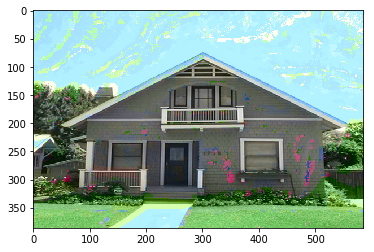

In [19]:
#print(np.sum(predicted_rgb < 0))
predicted_rgb = lab_to_rgb(predicted_image)
plt.imshow(predicted_rgb)

In [20]:
error,best_case = get_error(predicted_image[:,:,1:],original_ab[int(window/2):-int(window/2), int(window/2):-int(window/2)],centers,grayscale_test[int(window/2):-int(window/2), int(window/2):-int(window/2)])
print("Error: ")
print(error)

Error: 
22.873772359788546


In [21]:
predicted_lab = np.zeros((386,586,3))
predicted_lab[:,:,0] = grayscale_test[int(window/2):-int(window/2), int(window/2):-int(window/2)]
for i in range(386):
    for k in range(586):
        predicted_lab[i,k,1:] = centers[np.argmin(margin[i,k])]                           

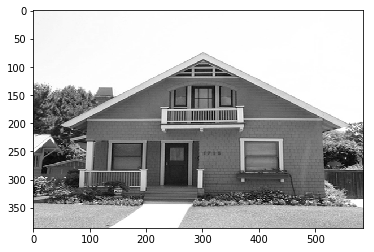

In [31]:
predicted_rgb = lab_to_rgb(predicted_lab)
plt.imshow(predicted_lab[:,:,0], cmap='gray')
plt.imsave("gray.jpg",predicted_lab[:,:,0], cmap='gray')

In [29]:
plt.imsave("result.jpg",predicted_rgb)
#necessary = (svm_arr, margin,centers)
# save the classifier
#with open('necessary.pkl', 'wb') as fid:
#     pickle.dump(necessary , fid)   

In [ ]:
#with open('necessary.pkl', 'rb') as fid:
#    necessary= pickle.load(fid)

In [ ]:
predicted_rgb = lab_to_rgb(best_case)
plt.imshow(predicted_rgb)